# Cracking the code for difficulty 1

## Crypto-analysis: length & frequency analysis

In this notebook, we discuss two types of crypto-analysis, which could help in cracking multiple cipher algorithms.
The first approach tries to find a matching cipher and plain text, to perform a so-called known-plain-text attack.
The second approach analysis the occurrence of the most common characters in both the cipher and plaintext documents.
Both techniques are visualised on the difficulty 1 ciphertexts, but can be used for other challenges as well (gathering more insights)

In [2]:
# Basic import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load text and ciphertexts in pandas dataframe
train = pd.read_csv('../input/training.csv', index_col='index')
train['length'] = train['text'].apply(lambda x: len(x))
# ceil the length of the plain texts and save locally (for matching plain and cipher texts)
train['length_100'] = (np.ceil(train['length'] / 100) * 100).astype(int)
test = pd.read_csv('../input/test.csv')
test['length'] = test['ciphertext'].apply(lambda x: len(x))

# 1. Length analysis plain vs difficulty 1
By exploiting the padding properties (each plaintext is padded with a certain number of characters), we can try to match different plain- to ciphertexts with rare lengths to construct so-called known attacks.

To show the advantage of length analysis, we will try to search for one difficulty 1 ciphertext and its corresponding plain text.
This (plain, ciphertext) pair can further be used to map character or perform further crypto-analyses.

In [4]:
# select difficulty 1 ciphertexts
diff1 = test[test['difficulty'] == 1]
# group the ciphertexts by length & sort the values 
lengths = diff1.groupby('length')['ciphertext'].count().sort_values()
# search for those cipher lengths which only once in our ciphertexts set
rare_lengths =  lengths[lengths == 1].index
# match them with the train (plaintext) set and count how many times we found a plaintext matching the length of the ciphertexts
train[train['length_100'].isin(rare_lengths)].groupby('length_100')['text'].count()

length_100
6100     9
6300     4
6400     3
6600     3
7200     3
7300     1
7700     1
8500     1
14200    1
Name: text, dtype: int64

**Seems like we found 4 (padded) lengths that only have 1 plain- and ciphertext of difficulty 1: 7300, 7700, 8500, 14200** 

We can now print these out. Take into account that padding has been added to all these texts.

In [5]:
matches = [7300, 7700, 8500, 14200]
train[train['length_100'].isin(matches)].sort_values('length_100')

,plaintext_id,text,length,length_100
index,,,,
20455,ID_4929f84c6,"With a new ""Spider-Man"" movie due out this May...",7286,7300
42847,ID_92319e9a4,***SPOILERS*** ***SPOILERS*** Getting the intr...,7601,7700
30914,ID_3de4e5b31,"""The Battle of Shaker Heights"" is the second o...",8442,8500
7533,ID_2f72f6bfb,***SPOILERS*** ***SPOILERS*** The first Godzil...,14126,14200


In [6]:
diff1[diff1['length'].isin(matches)].sort_values('length')

,ciphertext_id,ciphertext,difficulty,length
25841,ID_a6ecf7480,d$f8Gsxf!x[7472l}7bed!=lQnJ42b7Cv#!l7=yl7vyx7x...,1,7300
15989,ID_671657397,"P7T2e3gy9bwGjXDwm.OM8M8x8jbL!1}4amZRe""d-MTa[:o...",1,7700
23193,ID_a7cd22539,"F-{O}'*0T=I2 p9IW#B)TE[""cWX]""b/[l7*4xxOl7vz7e[...",1,8500
30578,ID_2462482ff,"quaZ!)Y*bu/ Mfl8Owj]H"" sj iv4khC1ZzhbIIIe'ZaG ...",1,14200


**These 4 texts can be used to investigate the underlying cipher algorithm  further**

# 2. Frequency analysis plain vs difficulty 1
Often, by inspecting the frequency of each symbol in the cipher's alphabet, the type of cipher which was applied can be easily determined.

In frequency analysis, the occurrence of each character in both the plain text and ciphertext is analysed. When for instance in the plaintext the space character occurs most of the time, and in the ciphertext, the '7' occurs very often,  there is a high probability that the space in the plaintext is mapped on the 7 in the ciphertext.

By repeating this procedure for all character occurrences, a mapping can be made.

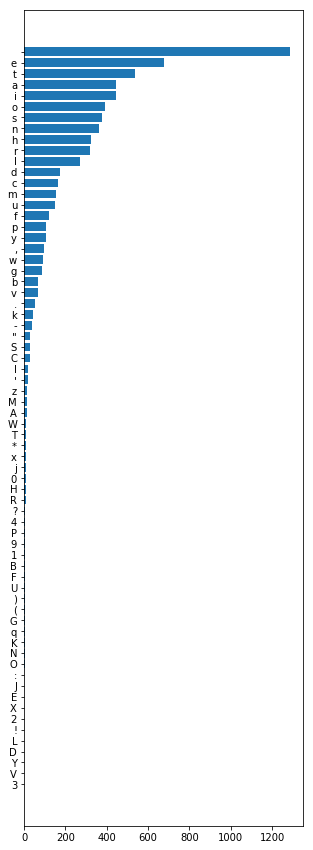

In [7]:
# Count occurences of charcters in the train plaintext (we used the ID_4929f84c6 plain text from the previous analysis)
plain_char_cntr = Counter(''.join(train[train.plaintext_id=='ID_4929f84c6']['text'].values))
# new dataframe with frequency and letter
plain_stats = pd.DataFrame([[x[0], x[1]] for x in plain_char_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
plain_stats = plain_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(plain_stats))) + 0.5, plain_stats['Frequency'].values)
plt.yticks(np.array(range(len(plain_stats))) + 0.5, plain_stats['Letter'].values)
plt.show()

# Space is the most occurring character, folowed by e, t, a, ...

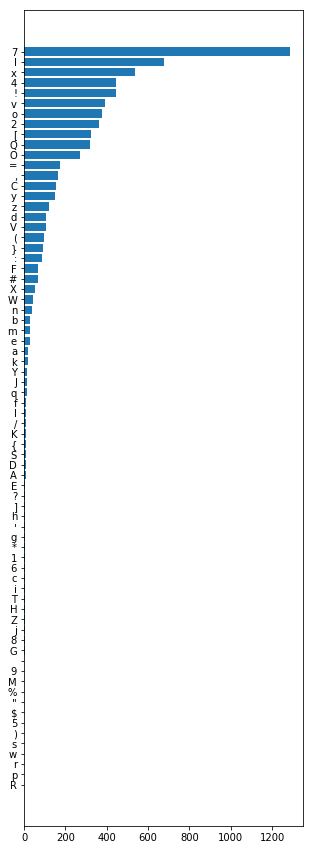

In [8]:
# same approach for ciphertext with id 'ID_a6ecf7480'
cipher_char_cntr = Counter(''.join(test[test['ciphertext_id'] == 'ID_a6ecf7480']['ciphertext'].values))
cipher_stats = pd.DataFrame([[x[0], x[1]] for x in cipher_char_cntr.items()], columns=['Letter', 'Frequency'])
cipher_stats = cipher_stats.sort_values(by='Frequency', ascending=True)

f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(cipher_stats))) + 0.5, cipher_stats['Frequency'].values)
plt.yticks(np.array(range(len(cipher_stats))) + 0.5, cipher_stats['Letter'].values)
plt.show()

# The bars match the training distribution very well! Most occurring character here is 7, followed by l, x, 4, ...

We see the occurence of characters are identical, which gives us an indication a substitution cipher was used between the plaintext and ciphertext of difficulty one. Creating a both alphabets is rather easy by matching them both based on the frequency.

In [9]:
# merge plaintext frequency stats together with the cipher text stats based on the Frequency scores
freq_alphabet = pd.merge(plain_stats, cipher_stats, on=['Frequency'])
# sort dataframe on frequency score
freq_alphabet = freq_alphabet.sort_values(by='Frequency', ascending=False)
# print first 20 rows of this dataframe
freq_alphabet.head(20)

,Letter_x,Frequency,Letter_y
197,,1286,7
196,e,679,l
195,a,445,4
194,i,444,!
193,o,390,v
192,s,379,o
191,n,363,2
190,h,325,[
189,r,321,Q
188,l,269,O


We see these Letter_x (plaintext) characters are mapped exactly on Letter_y (ciphertext) characters.

**Of course, one pair of (plaintext, ciphertext) will not be sufficient to get the full substitution alphabet (the same frequencies occur for less occurring characters). But using this technique, we can find more and more pairs of (ciphertext, plaintexts), providing us with more information about the used substitutions. **

We manually corrected the small number of mistakes in our mapping, since it is important to have this mapping as correct as possible, since it will help further analysis of more difficult ciphertexts. **The manual correction step is rather tedious. If you have any neat tools or other heuristics for that, please comment!**

In [14]:
# Manually fix the mapping for the remainining characters
alphabet = """7lx4v!2oQ[O=,yCzV:}dFX#(Wak/bqne*JApK{cmf6 GZDj9gT\'"YSHiE]5)81hMNwI@P?Us%;30uBrLR-.$t"""
key =      """ etaoinsrhldcumfygwpb.v,kI\'T"A-SBMxDHj)CW(ELORN!FGPJz0qK?1VY:U92/3*5;478QZ6X%$}#@={[]"""

decrypt_mapping = {}
encrypt_mapping = {}
for i, j in zip(alphabet, key):
    decrypt_mapping[ord(i)] = ord(j)
    encrypt_mapping[ord(j)] = ord(i)

def encrypt_step1(x):
    return x.translate(encrypt_mapping)

def decrypt_step1(x):
    return x.translate(decrypt_mapping)

In [15]:
cipher = test[(test['difficulty'] == 1)].sample(1).iloc[0, :]['ciphertext']
print(decrypt_step1(cipher))

pQM#mHNHxKy7NXgZJZuAy[xG=H,HWjF%emxOh dear, what a let-down. This movie left me with the feeling that two hours of my life had been stolen. OK, so this is Jack Ryan before Patriot Games (given that he's unmarried ... the movie is unclear on the time when it's set), so he has to be young, but Harrison Ford managed to portray Ryan as a nice guy, insecure but fundamentally smart, and Affleck just can't do it. He tries hard, but is handicapped ]ironically{ by his good looks and boyish smile.   What is even worse is that the script does Affleck no favours. ]SPOILER ALERT{. He makes a crucial phone call to someone who doesn't trust him and fails to put the key information in the first sentence? That's fundamentally stupid. He dashes around the world like a demented chicken rather than staying cool and making a few phone calls? And then there's the plot holes: John Clark can't or won't speak Russian? He doesn't seem to know that most Ukrainians understand Russian? Cathy gets knocked over - in